# Modeling and Simulation in Python

### Course: Data 604 - Final Project
### Name: Sachid Deshmukh
### Date: 07/18/2020


### 1.  State the problem and its significance.

### Problem Statement: Simulate Covid-19 infections and deaths for the state of New York and analyse the effect of social distancing on final outcome (# infections and deaths)

#### This project uses an actual Covid-19 dataset for New York State. Following are the goals of the project.
- Analyze open source Covid-19 data available for New York State
- Devide data into two parts based on severity of social distancing followed (No Social Distancing vs Social Distancing)
- Develop mathematical simulation to fit actual Covid-19 data for New York State (Use linear interpolation)
- Identify Infection Rate and Death Rate between No Social Distancing period and Social Distancing period (Using mathematical model through simulation)
- Perform "What If" analysis: The impact of social distancing on the final outcome (# of Infections and # of deaths)

#### This project answers a critical question: "How many lives could have been saved if we followed Social Distancing earlier in the state of New York during Covid-19 Pandemic"

#### Data is obtained from following open source github repo

#### Data Set Location: https://github.com/datasets/covid-19/tree/master/data

**Note** : Data is filtered and aggregated to reflect Covid-19 stats only for the state of New York. In the original git repo, there are two separate datasets for tracking infections and deaths. For the purpose of this project, data is already pre-processed by combining two separate datasets (infections and deaths) into one consolidated dataset

### 2.  Provide a flow-chart model. 

#### This project assumes a simplified process of Covid-19 spread. Following is the flow chart model used for this simulation


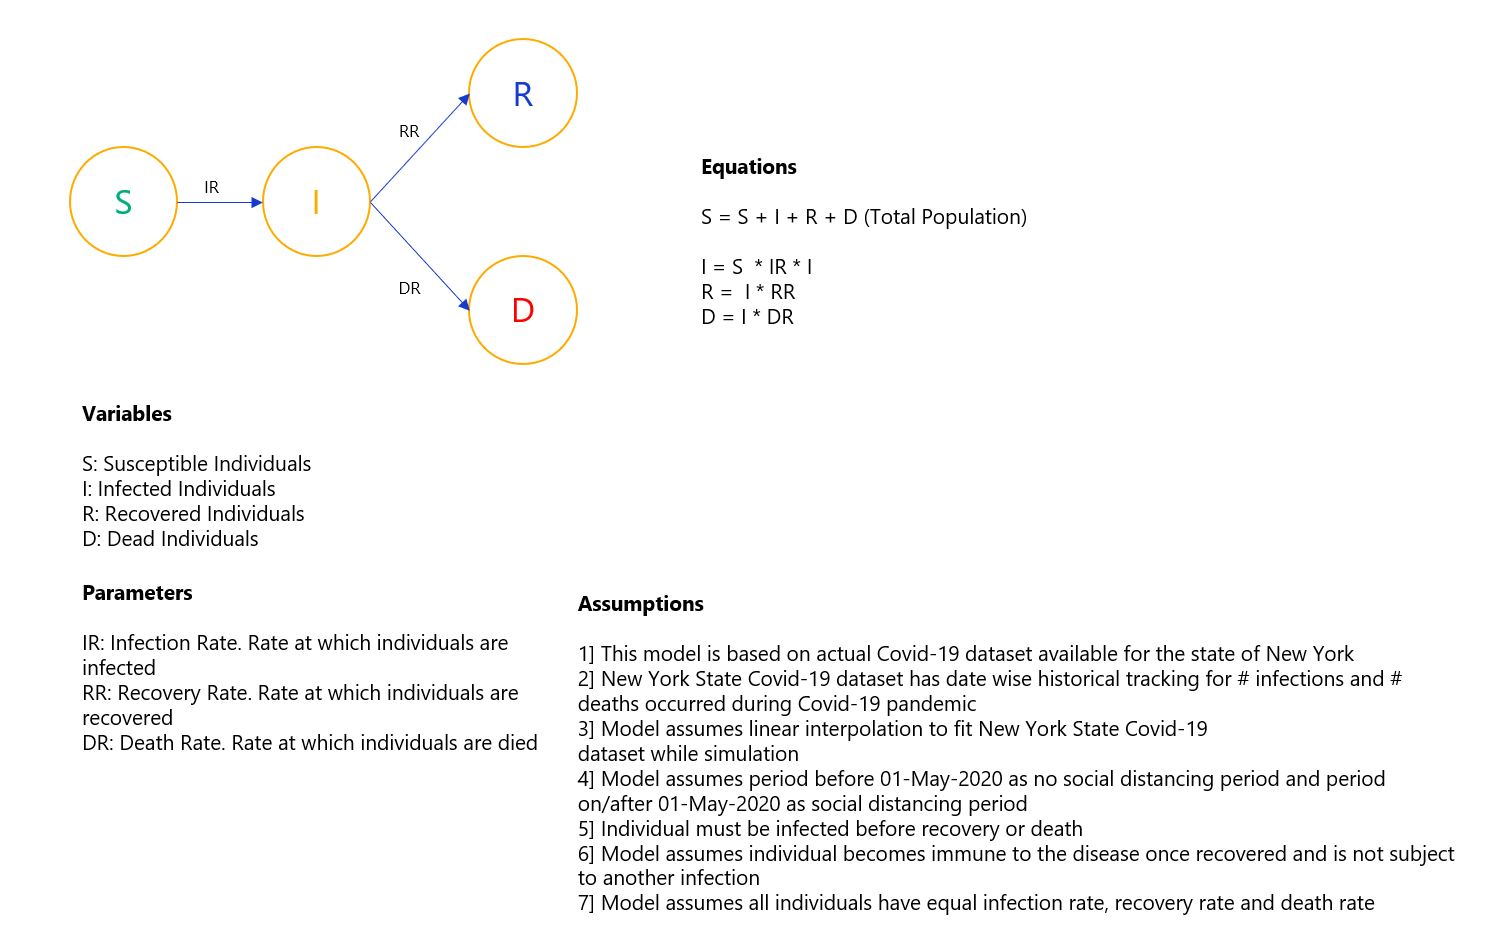

### 3.  Simulate the process for the appropriate number of iterations (justify)

#### Import required packages

In [ ]:
from modsim import *
import pandas as pd
import numpy as np

#### Utility Functions

In [2]:
def draw_plot(data, style, label, xlabel, ylabel, title):
    plot(data, style, label=label)
    decorate(xlabel=xlabel,
         ylabel=ylabel,
         loc='center left',
            title = title)


In [3]:
def make_system(socdiststart, socstartinf, socstartdead):
    init = State(S=400000, I=0, R=0, D=0)
   
    t0 = 0
    t_end = 132
    socstartinf =  socstartinf 
    socstartdead = socstartdead 
    IR1 = 6074.90 # Infection rate before Social Distancing
    IR2 = 1133.79 # Infection rate after Social Distancing
    DR1 = 0.105 # Death rate before Social Distancing
    DR2 = 0.107 # Death rate after Social Distancing
    return System(init=init, t0=t0, t_end=t_end, socdiststart = socdiststart, socstartinf = socstartinf, socstartdead = socstartdead, IR1 = IR1, IR2 = IR2, DR1 = DR1, DR2 = DR2 )

In [4]:
def update_func(state, t , system):
    
    s, i, r, d = state
    socstartinf = system.socstartinf
    socstartdead = system.socstartdead
    socstart = system.socdiststart
    infected = i
    dead = d
    if(t <= socstart):
        infected = -67144.27 + t * system.IR1
        dead = 894.12 + (-157.65 * t) + (system.DR1 * infected)
    else:
        infected = (socstartinf - 50000) + t * system.IR2
        dead = (socstartdead - 32000) + (-36.12 * t) + (system.DR2 * infected)
    if(infected < 0):
        infected = 0
    if(dead < 0):
        dead = 0
    
    s -= infected
    i = infected
    d = dead
    r = i - d
    
    return State(S=s, I=i, R=r, D = d)

In [5]:
def run_simulation(system, update_func):
  
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [6]:
def calcMape(actual, fitted):
    mape = np.sum(np.abs(actual - fitted))/np.sum(actual)
    return mape

def calcPer(before, after):
    diff = before - after
    per = 100 * diff/before
    return per

#### Read input data

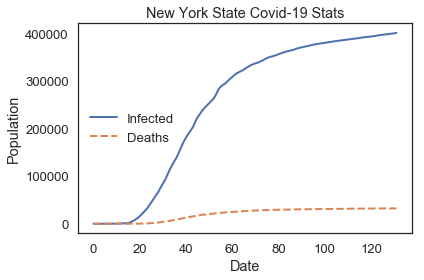

In [7]:
df_input = pd.read_csv('NewYork_Covid.csv')
draw_plot(df_input.Infected, '-', 'Infected', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(df_input.Death, '--', 'Deaths', 'Date', 'Population', 'New York State Covid-19 Stats')

#### From the above dataset, we can see that we have data for four and half months (132 days). Starting from March-2020 to mid
#### July-2020. We can see that there is a curve flattening effect after two Months (60 days). Starting from May-2020 there seems to be
#### change in infection rate as well as death rate. We can say that this is due to the stringent measures in social distancing 
#### followed in the state of New York. Based on above plot we can devide this data into two time periods
- No Social Distancing: All the data before May-2020 can be categorized as No Social Distancing period
- Social Distancing: All the data after May-2020 can be categorized as Social Distancing period

#### Run Covid-19 simulation for 132 days (total data points from actual dataset are equal to 132) with Social Distancing starting from 60 days after infection start date and plot # Infections and Deaths from actual covid-19 dataset for the state of newyork and from our simulation

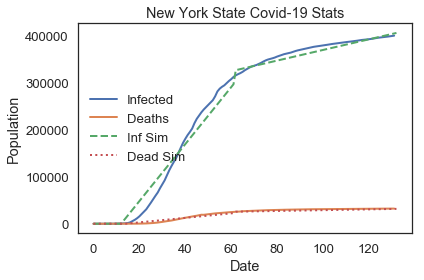

In [8]:
socdiststart = 60
system = make_system(socdiststart,df_input.iloc[socdiststart,1], df_input.iloc[socdiststart,2] )
results_60 = run_simulation(system, update_func)
df_input = pd.read_csv('NewYork_Covid.csv')
draw_plot(df_input.Infected, '-', 'Infected', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(df_input.Death, '-', 'Deaths', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(results_60.I, '--', 'Inf Sim', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(results_60.D, ':', 'Dead Sim', 'Date', 'Population', 'New York State Covid-19 Stats')


### 4.  Justify the validity of the model and discuss how you verified it.

#### Model Verification
Model assumes linear interpolation for fitting actual Covid-19 data observed for the state of New York while coming up with simulation
From the graph above we can see that simulated curve nicely fits the actual curve. We can see that actual curve is not purely linear however linear interpolation seems to be doing a pretty good job while fitting the actual curve with some exception

Model also uses linear functions for simulation

I = Constant + (time * IR)
Where IR = Infection Rate

D = Constant +  (I * DR)
Where DR = Death Rate

**Note: IR and DR varies between period where no social distancing is followed and for period where social distancing was followed**

#### Model Validation

We can quantify how best model is fitting the actual data through measure like Mean Absolute Percentage Error

**MAPE = Sum(ABS(Actual - Fitted)) / Sum(Actual)**

Where 

Actual - Actual observed value

Fitted - Fitted value through simulation


In [9]:
print('MAPE for Infected Population is %s' %calcMape(df_input.Infected, results_60.I))
print('MAPE for Dead Population is %s' %calcMape(df_input.Death, results_60.D))

MAPE for Infected Population is 0.04437156933708165
MAPE for Dead Population is 0.09111810031331245


We can see the error rate for fitting Infected population is 4.4% and Dead population is 9%. That means we can simulate 
results for Infected population with ~96% accuracy and for Dead population with ~91% accuracy which is not that bad

In [10]:
print('Total Infections (Actual) = %s' %get_last_value(df_input.Infected))
print('Total Infections (Simulation) = %s' %get_last_value(results_60.I))
print('Total Deaths (Actual) = %s' %get_last_value(df_input.Death))
print('Total Deaths (Simulation) = %s' %get_last_value(results_60.D))

Total Infections (Actual) = 401029
Total Infections (Simulation) = 406840.49
Total Deaths (Actual) = 32343
Total Deaths (Simulation) = 31721.21243


We can see that # infections and deaths from actual data closely matches with simulated values when we ran this simulation for 132 days

### 5.  State  your conclusions/ findings from the model. 

#### 1. How many less infections and deaths would have been if the social distancing measures were taken from 50 days since infection start

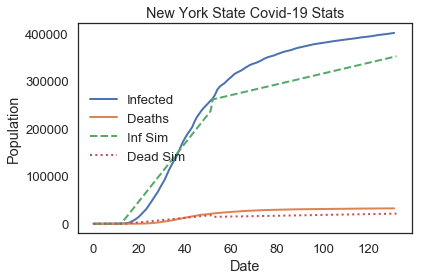

In [11]:
socdiststart = 50
system = make_system(socdiststart,df_input.iloc[socdiststart,1], df_input.iloc[socdiststart,2] )
results_50 = run_simulation(system, update_func)
df_input = pd.read_csv('NewYork_Covid.csv')
draw_plot(df_input.Infected, '-', 'Infected', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(df_input.Death, '-', 'Deaths', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(results_50.I, '--', 'Inf Sim', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(results_50.D, ':', 'Dead Sim', 'Date', 'Population', 'New York State Covid-19 Stats')

In [12]:
print('Percentage Reduction in Infections = %s'% calcPer(get_last_value(results_60.I), get_last_value(results_50.I)))
print('Percentage Reduction in Deaths = %s'% calcPer(get_last_value(results_60.D), get_last_value(results_50.D)))

Percentage Reduction in Infections = 13.468423460015005
Percentage Reduction in Deaths = 32.889868327142004


Number of Infections would have been reduced by 13% and Number of Deaths would have been reduced by 32% if Social Distancing measures would have taken after 50 days from infection start date

#### 2. How many less infections and deaths would have been if the social distancing measures were taken from 40 days since infection start

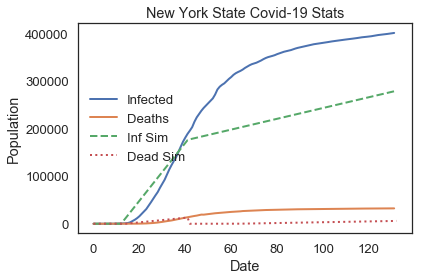

In [13]:
socdiststart = 40
system = make_system(socdiststart,df_input.iloc[socdiststart,1], df_input.iloc[socdiststart,2] )
results_40 = run_simulation(system, update_func)
df_input = pd.read_csv('NewYork_Covid.csv')
draw_plot(df_input.Infected, '-', 'Infected', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(df_input.Death, '-', 'Deaths', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(results_40.I, '--', 'Inf Sim', 'Date', 'Population', 'New York State Covid-19 Stats')
draw_plot(results_40.D, ':', 'Dead Sim', 'Date', 'Population', 'New York State Covid-19 Stats')

In [14]:
print('Percentage Reduction in Infections = %s'% calcPer(get_last_value(results_60.I), get_last_value(results_40.I)))
print('Percentage Reduction in Deaths = %s'% calcPer(get_last_value(results_60.D), get_last_value(results_40.D)))

Percentage Reduction in Infections = 31.28695474730158
Percentage Reduction in Deaths = 81.21951850627924


Number of Infections would have been reduced by 31% and Number of Deaths would have been reduced by 81% if Social Distancing measures would have taken after 40 days from infection start date

#### 3. Plot the reduction in # infections and deaths as a function of Social Distancing

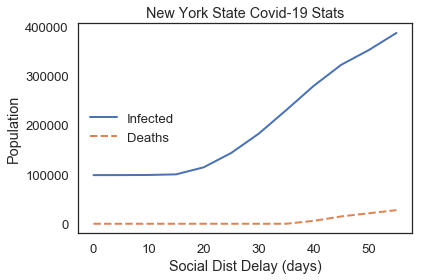

In [15]:
soc_dist = linrange(0,60, 5)
frame = TimeFrame(columns=['SocDist', 'I', 'D'])
i = 0
for dist in soc_dist:
    system = make_system(dist,df_input.iloc[dist,1], df_input.iloc[dist,2] )
    results = run_simulation(system, update_func)
    frame.row[i] = [dist, get_last_value(results.I), get_last_value(results.D)]
    i = i + 1

frame.index = frame.SocDist
  
draw_plot(frame.I, '-', 'Infected', 'Social Dist Delay (days)', 'Population', 'New York State Covid-19 Stats')
draw_plot(frame.D, '--', 'Deaths', 'Social Dist Delay (days)', 'Population', 'New York State Covid-19 Stats')


We can see from the above plot that as we delay social distancing measures there is exponential increase in the # infections and # deaths. We can also establish a fact that optimum delay in social distancing is 20 days. After 20 days there is an exponential increase in # infections and deaths. From the above plot we can conclude that we would have been able to save lots of lives in the state of New York if social distancing measures would have been followed after 20 days from the infection start date